In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import  numpy as np

from time import time
from datetime import timedelta

# importing pacakge 
import sys         
sys.path.append(r'C:\Users\omirinioui\PycharmProjects\Hadil_proj\Code\Bayesian Quad for CVA\BQ CVA Swaps Multi RF\libraries')        

from main import *
from FinancialData import *

from Chebychev import eval_Barycentric , Chebyshev_points

In [25]:
ZCR = ZC_Data_extractor("R:/DR-NATIXIS/ERM/MCRM/LeaderExpert/Stagiaires/2023")
ZC = zero_coupon_bonds(ZCR, 3) # We chose 3 as degree of the Spline Interpolation 

nbr_fx =  10
nbr_swap = 600
portfolio = Multi_FX_irs_portfolio( nbr_fx, nbr_swap)

#load portfolio data
port_path = r'C:\Users\omirinioui\PycharmProjects\Hadil_proj\Code\Bayesian Quad for CVA\BQ CVA Swaps Multi RF\Data\portfolio'
portfolio.reset_portfolio_from_excel(port_path, '\port600irs10fx.xlsx')

T = portfolio.last_maturity
portfolio.irs_specs

array([(0., 0.25, 100000., 0.04473561, 2.5, 'reciver', 7),
       (0., 0.25,  70000., 0.0495388 , 1. , 'payer', 3),
       (0., 0.25,  90000., 0.04679434, 1. , 'payer', 9),
       (0., 0.5 ,  60000., 0.02958941, 7. , 'payer', 6),
       (0., 1.  ,  40000., 0.0377977 , 6.5, 'reciver', 3),
       (0., 1.  ,  90000., 0.02586477, 7.5, 'reciver', 5),
       (0., 1.  ,  20000., 0.0458065 , 4.5, 'reciver', 6),
       (0., 0.5 ,  10000., 0.04592901, 2. , 'payer', 1),
       (0., 1.  , 100000., 0.02235853, 2. , 'payer', 9),
       (0., 0.25, 100000., 0.04150736, 6.5, 'reciver', 6),
       (0., 0.25,  10000., 0.04176027, 2. , 'payer', 8),
       (0., 0.25,  50000., 0.04205143, 7.5, 'reciver', 2),
       (0., 0.5 , 100000., 0.04384751, 4. , 'payer', 6),
       (0., 0.25, 100000., 0.03102544, 3. , 'payer', 2),
       (0., 0.25,  30000., 0.04814816, 3. , 'payer', 6),
       (0., 0.5 ,  60000., 0.03369468, 3. , 'payer', 9),
       (0., 0.25, 100000., 0.04944313, 5.5, 'reciver', 7),
       (0., 1.  ,

In [6]:
#load diffusion data
diff_path = r'C:\Users\omirinioui\PycharmProjects\Hadil_proj\Code\Bayesian Quad for CVA\BQ CVA Swaps Multi RF\Data\diffusion'
with open(diff_path+'\MC10000p600s10f', 'rb') as f1:
    diffusion = pickle.load(f1)

In [7]:
#load MC data
MC_path = r'C:\Users\omirinioui\PycharmProjects\Hadil_proj\Code\Bayesian Quad for CVA\BQ CVA Swaps Multi RF\Results\Full MC'
with open(MC_path+'\EE_MC_P600sf10', 'rb') as f1:
    mc_df = pickle.load(f1)
    EE_MC = pickle.load(f1)

## CVA by Bayesian Quadrature :

In [8]:
#recovery rate & defult probability parameter :
R, lamda = 0.4, 0.005

In [9]:
Expected_exposure_MC(0, portfolio, diffusion, [ZC for i in range(nbr_fx)], Chebychev=True, train_size=15)

0.0

time : 10.719486951828003
Nodds numbers 5


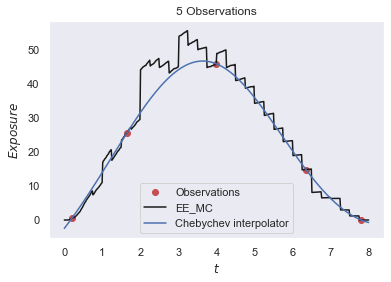

time : 22.789485692977905
Nodds numbers 10


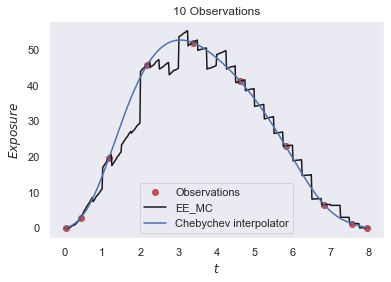

time : 35.33121967315674
Nodds numbers 15


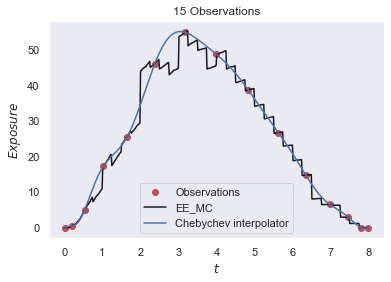

time : 70.05872392654419
Nodds numbers 20


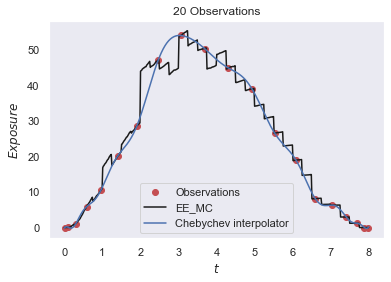

time : 99.86882495880127
Nodds numbers 25


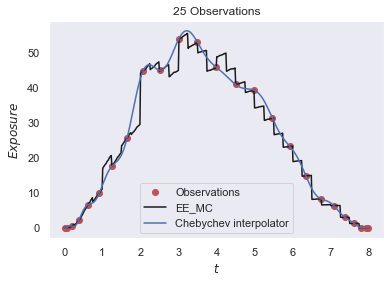

time : 102.4309549331665
Nodds numbers 30


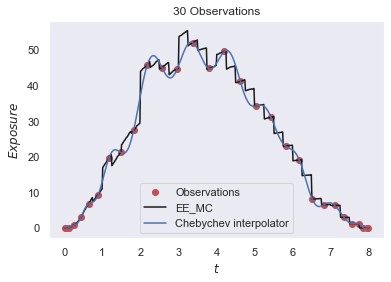

time : 121.72070860862732
Nodds numbers 35


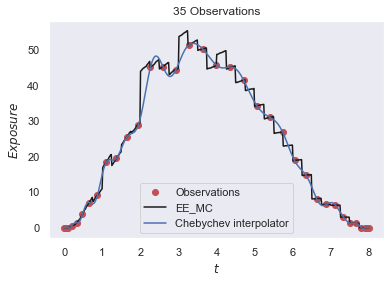

KeyboardInterrupt: 

In [22]:
img_path = r'C:\Users\omirinioui\PycharmProjects\Hadil_proj\Code\Bayesian Quad for CVA\BQ CVA Swaps Multi RF\Results\Images'

train_size_on_x = 15
lb , ub = 0,T
x_plot = np.linspace(lb, ub, 300)[:, None]

integration_grid = np.linspace(0,T,500)
d = 5
nd = 8

bq_df = pd.DataFrame(columns=['Nodes Number','BQ-Chebychev', 'time'])

for i in range(nd):
    start_time = time()
   
    integ_points = Chebyshev_points(0, T, (i+1)*d)[::-1]

    EE = np.array([ Expected_exposure_MC(t, portfolio, diffusion, [ZC for i in range(nbr_fx)], Chebychev=True, train_size=train_size_on_x)  for t in integ_points ])
    PD = np.array([ lamda * np.exp(-lamda *t) for t in integ_points])
    Y = (1-R)*EE*PD
    
    
    EE_cheb = np.array([eval_Barycentric(EE, integ_points, t) for t in integration_grid])
    
    PD = np.array([ lamda * np.exp(-lamda *t) for t in integration_grid ])
    Y_cheb = (1-R)*EE_cheb*PD
    cva = (np.diff(integration_grid)*Y_cheb[1:]).sum()
    
    
    sec_time =time()-start_time
    print('time :', sec_time)
    
    bq_df.loc[len(bq_df)] = [(i+1)*d,cva ,sec_time]
    
    PD_full = np.array([ lamda * np.exp(-lamda *t) for t in np.linspace(0,T,len(EE_MC)) ])
    Y_MC = (1-R)*EE_MC*PD_full
    

    print('Nodds numbers', (i+1)*d)
    plt.figure()
    plt.plot(integ_points, Y, "ro", markersize=6, label="Observations")
    plt.plot(np.linspace(0,T,len(EE_MC)), Y_MC, "k", label="EE_MC")

    plt.plot(integration_grid, Y_cheb, "C0", label="Chebychev interpolator")

    plt.legend()
    plt.xlabel(r"$t$")
    plt.ylabel(r"$Exposure$")
    plt.grid(False)
    plt.title( str((i+1)*d) + ' Observations')
    plt.savefig(img_path+ '/P600F10_Chebychev_Chebychev__trained'+str(train_size_on_x)+'X'+ str(i)+'t'+'.png')
    plt.show()

In [23]:
idx = 4
bq = bq_df.copy()
bq['Relative_Error %'] = bq_df['BQ-Chebychev'].apply(lambda x: 100*abs(x - mc_df.iloc[idx]['CVA MC'] )/mc_df.iloc[idx]['CVA MC'] )
bq['Time Reduction'] =  bq_df['time'].apply(lambda x: int(mc_df.iloc[idx]['time']/x) )
bq.round(2)


,Nodes Number,BQ-Chebychev,time,Relative_Error %,Time Reduction
0,5.0,197.40,10.72,6.30,130
1,10.0,218.53,22.79,3.73,61
2,15.0,217.61,35.33,3.29,39
3,20.0,208.77,70.06,0.90,19
4,25.0,214.88,99.87,2.00,13
5,30.0,206.57,102.43,1.95,13
6,35.0,206.51,121.72,1.98,11
